# ▶️ Part 1: **1st Person.ipynb**

# Shard 1 (0-25%)

In [ ]:
!pip install -q youtube-transcript-api pandas numpy matplotlib seaborn langdetect tqdm
from google.colab import drive
import os

if not os.path.exists('/content/drive/My Drive'):
    try:
      drive.flush_and_unmount()
    except ValueError:
      pass
    if os.path.exists('/content/drive'):
        !rm -rf /content/drive
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
else:
    print("Google Drive is already mounted.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.1/485.1 kB 19.4 MB/s eta 0:00:00
Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
Google Drive mounted successfully.


Pathway

In [ ]:
import os, math, pandas as pd, numpy as np
BASE = "/content/drive/MyDrive/Final EGBI222 Group Project"
CHUNK = f"{BASE}/chunks"; os.makedirs(CHUNK, exist_ok=True)
print(f"Base file folder set to: {BASE}")
print(f"Chunks folder set to: {CHUNK}")

Base file folder set to: /content/drive/MyDrive/Final EGBI222 Group Project
Chunks folder set to: /content/drive/MyDrive/Final EGBI222 Group Project/chunks


Load Dataset

In [ ]:
CSV = f"{BASE}/youtube_data.csv"
df = pd.read_csv(CSV).copy()
if 'video_id_clean' not in df.columns and 'video_id' in df.columns:
    df['video_id_clean'] = df['video_id'].astype(str)
ID = 'video_id_clean' if 'video_id_clean' in df.columns else 'video_id'
df = df.reset_index(drop=True); df['row_no'] = df.index + 1

Quater1 slice

In [ ]:
N = len(df); q1 = math.ceil(N/4)
lo, hi = 1, q1
df_small = df[(df['row_no']>=lo)&(df['row_no']<=hi)].copy().reset_index(drop=True)
print(f"P1 rows {lo}-{hi}/{N} → {len(df_small)}")

P1 rows 1-4398/17589 → 4398


Captions

In [ ]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound, VideoUnavailable
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect
from tqdm import tqdm

def fetch_cap(vid):
    vid = str(vid)
    try:
        trs = YouTubeTranscriptApi.list_transcripts(vid)
        text = ""
        lang = 'unknown'
        source = 'yt_caption'

        try:
            tr = trs.find_transcript(['en'])
            lang = 'en'
            segs = tr.fetch()
            text = " ".join(s.get('text','') for s in segs if s.get('text'))
        except NoTranscriptFound:
            try:
                tr = next(iter(trs))
                lang = tr.language_code or 'unknown'
                segs = tr.fetch()
                text = " ".join(s.get('text','') for s in segs if s.get('text'))
            except Exception:
                text = ""
                lang = "unknown"
                source = "no_caption"
        except Exception:
             text = ""
             lang = "unknown"
             source = "no_caption"


        lg = 'unknown'
        if text.strip():
            try: lg = detect(text)
            except: lg = lang or 'unknown'
        return vid, text, lg, source
    except (TranscriptsDisabled, NoTranscriptFound, VideoUnavailable, Exception):
        return vid, "", "unknown", "no_caption"

vids = df_small[ID].astype(str).tolist()
rows = []
with ThreadPoolExecutor(max_workers=32) as ex:
    futs = {ex.submit(fetch_cap, v): v for v in vids}
    for f in tqdm(as_completed(futs), total=len(futs), desc="P1 captions"):
        rows.append(f.result())

cap = pd.DataFrame(rows, columns=[ID,'transcript','lang_guess','source'])
out = df_small[[ID,'title','description'] if 'title' in df_small.columns or 'description' in df_small.columns else [ID]].merge(cap, on=ID, how='left')

P1 captions: 100%|██████████| 4398/4398 [00:00<00:00, 147347.25it/s]


Metadata fallback (title/description)

In [ ]:
title_col = 'title' if 'title' in df_small.columns else None
desc_col  = 'description' if 'description' in df_small.columns else None
if title_col or desc_col:
    mask = (out['transcript'].isna()) | (out['transcript']=="")
    if title_col and desc_col:
        out.loc[mask,'transcript'] = (df_small.loc[mask, title_col].fillna('') + " " +
                                      df_small.loc[mask, desc_col].fillna('')).str.strip()
    elif title_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, title_col].fillna('')
    elif desc_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, desc_col].fillna('')
    out.loc[mask & (out['lang_guess'].isna() | (out['lang_guess']=="unknown")), 'lang_guess'] = 'unknown'
    out.loc[mask & (out['source'].isna()), 'source'] = 'meta_fallback'

mask_no_caption_no_meta = (out['source'] == 'no_caption') & ((out['transcript'].isna()) | (out['transcript']==""))
out.loc[mask_no_caption_no_meta, 'lang_guess'] = 'unknown'
out.loc[mask_no_caption_no_meta, 'source'] = 'no_caption'

Save shard

In [ ]:
shard = f"{CHUNK}/transcripts_p1_{lo}-{hi}.csv"; out.to_csv(shard, index=False); print("Saved shard:", shard)

Saved shard: /content/drive/MyDrive/Final EGBI222 Group Project/chunks/transcripts_p1_1-4398.csv


Transcript to English

In [ ]:
!pip -q install langdetect==1.0.9 deep-translator==1.11.4 tqdm==4.66.5

from google.colab import drive
from langdetect import detect, DetectorFactory, LangDetectException
from deep_translator import GoogleTranslator, MyMemoryTranslator
from tqdm.auto import tqdm
import pandas as pd, numpy as np
import os, re, time, random, sys

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

BASE   = "/content/drive/MyDrive/Final EGBI222 Group Project"
IN_CSV = os.path.join(BASE, "chunks", "transcripts_p1_1-4398.csv")
OUTDIR = os.path.join(BASE, "chunk2")
OUT_CSV = os.path.join(OUTDIR, "transcripts_en_p1_1-4398.csv")
AUDIO_DIR = f"{BASE}/audio"

os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(AUDIO_DIR, exist_ok=True)
print("Input :", IN_CSV)
print("Output:", OUT_CSV)

try:
    df = pd.read_csv(IN_CSV)
    if 'transcript' not in df.columns:
        for c in ['text', 'caption', 'content']:
            if c in df.columns:
                df = df.rename(columns={c: 'transcript'})
                break
    if 'transcript' not in df.columns:
        raise KeyError("Input must contain a 'transcript' column (or one of ['text','caption','content']).")
    print(f"Loaded rows: {len(df)}")
except Exception as e:
    print(f"[FATAL] Could not load input CSV: {e}")
    raise

def clean_text(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("\u200b","").replace("\u200c","").replace("\u200d","").replace("\ufeff","")
    s = re.sub(r"[\u0000-\u0008\u000B\u000C\u000E-\u001F\u007F]", "", s)
    s = re.sub(r"[^\S\r\n\t]+", " ", s).strip()
    s = re.sub(r"(.)\1{5,}", r"\1\1\1\1\1", s)
    return s

tqdm.pandas(desc="Cleaning")
df['transcript'] = df['transcript'].progress_apply(clean_text)
df = df[df['transcript'].str.strip() != ""].copy()
print("Rows after cleaning:", len(df))

DetectorFactory.seed = 0

def quick_ascii_english(s: str) -> bool:
    """Fast check: mostly ASCII & contains vowels/spaces -> likely English."""
    if not s: return False
    if not all(ord(ch) < 128 for ch in s):
        return False
    return bool(re.search(r"[aeiouAEIOU]", s))

def detect_lang_safe(s: str) -> str:
    s = (s or "").strip()
    if not s: return "und"
    if quick_ascii_english(s):
        return "en"
    try:
        return detect(s) or "und"
    except LangDetectException:
        return "und"
    except Exception:
        return "und"

if 'lang' not in df.columns:
    tqdm.pandas(desc="Detecting language")
    df['lang'] = df['transcript'].progress_apply(detect_lang_safe)
else:
    mask_unknown = df['lang'].astype(str).str.lower().isin(['unknown','und','','nan']) | df['lang'].isna()
    if mask_unknown.any():
        tqdm.pandas(desc="Re-detecting language")
        df.loc[mask_unknown, 'lang'] = df.loc[mask_unknown, 'transcript'].progress_apply(detect_lang_safe)
    df.loc[df['lang'].astype(str).str.lower().isin(['unknown','','nan']) | df['lang'].isna(), 'lang'] = 'und'

print("Language counts:\n", df['lang'].value_counts(dropna=False))

BATCH_SIZE = 80
MAX_TRIES  = 3
BASE_SLEEP = 0.6

if 'transcript_en' not in df.columns:
    df['transcript_en'] = ""

mask_en = df['lang'].astype(str).str.lower().eq('en')
df.loc[mask_en, 'transcript_en'] = df.loc[mask_en, 'transcript']

def translate_batch_google(texts, src_lang):
    """Batch translate via GoogleTranslator with retries. Returns list[str]."""
    texts = [("" if pd.isna(t) else str(t)) for t in texts]
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"
    out = list(texts)
    for attempt in range(1, MAX_TRIES+1):
        try:
            gt = GoogleTranslator(source=src, target='en')
            res = gt.translate_batch(texts)
            if isinstance(res, list) and len(res) == len(texts):
                out = [r if (isinstance(r, str) and r.strip() != "") else orig for r,orig in zip(res, texts)]
                return out
        except Exception as e:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))
    return out

def translate_item_fallback(text, src_lang):
    """Per-item fallback using Google first, then MyMemory."""
    if not text: return ""
    if quick_ascii_english(text): return text
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = GoogleTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = MyMemoryTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    return text

lang_order = df['lang'].value_counts().index.tolist()
lang_order = [l for l in lang_order if str(l).lower() not in ('en','und')] + (['und'] if 'und' in lang_order else [])

for lc in lang_order:
    mask = (df['lang'] == lc) & (df['transcript'].str.strip() != "") & (df['transcript_en'].str.strip() == "")
    idxs = df.index[mask].tolist()
    if not idxs:
        continue

    texts = df.loc[idxs, 'transcript'].tolist()
    translated = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"{lc}->en (batch)"):
        chunk = texts[i:i+BATCH_SIZE]
        out = translate_batch_google(chunk, lc)

        fixed = []
        for orig, got in zip(chunk, out):
            if (not got.strip()) or (got.strip() == orig.strip() and not quick_ascii_english(orig)):
                fixed.append(translate_item_fallback(orig, lc))
            else:
                fixed.append(got)
        translated.extend(fixed)

    df.loc[idxs, 'transcript_en'] = translated

need_fix = (df['transcript_en'].str.strip() == "")
if need_fix.any():
    print(f"Rescue pass on {need_fix.sum()} rows…")
    for idx in tqdm(df.index[need_fix], desc="rescue"):
        src = df.at[idx, 'lang']
        txt = df.at[idx, 'transcript']
        df.at[idx, 'transcript_en'] = translate_item_fallback(txt, src)

df['transcript_en'] = df['transcript_en'].fillna("")

if 'lang' in df.columns:
    df = df.drop(columns=['lang'])

try:
    df.to_csv(OUT_CSV, index=False, encoding='utf-8')
    print("✅ Saved:", OUT_CSV)
except Exception as e:
    print(f"❌ Save error: {e}")
    raise

cols = ['video_id_clean' if 'video_id_clean' in df.columns else ('video_id' if 'video_id' in df.columns else df.columns[0]),
        'transcript','transcript_en']
print("\nHead:")
print(df[cols].head(3))
print("\nDone.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.5 which is incompatible.
Google Drive is already mounted.
Input : /content/drive/MyDrive/Final EGBI222 Group Project/chunks/transcripts_p1_1-4398.csv
Output: /content/drive/MyDrive/Final EGBI222 Group Project/chunk2/transcripts_en_p1_1-4398.csv
Loaded rows: 4398


Cleaning:   0%|          | 0/4398 [00:00<?, ?it/s]

Rows after cleaning: 4397


Detecting language:   0%|          | 0/4397 [00:00<?, ?it/s]

Language counts:
 lang
en       3276
es        170
pt        148
ar         80
ja         80
ru         77
fr         76
ko         68
de         59
pl         37
und        34
it         31
th         27
vi         24
tr         21
cs         18
bg         14
hu         13
sv         11
ca         11
no         11
he         11
sk          9
sl          8
el          8
so          8
id          7
zh-tw       7
da          6
nl          6
mk          4
fa          4
zh-cn       4
et          4
ro          4
sw          4
uk          4
fi          3
hr          3
cy          2
tl          2
lt          1
bn          1
sq          1
Name: count, dtype: int64


es->en (batch):   0%|          | 0/3 [00:00<?, ?it/s]

pt->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

ar->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ja->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ru->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ko->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

de->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

pl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

it->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

th->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

vi->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

tr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

cs->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

bg->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

hu->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sv->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ca->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

no->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

he->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

el->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

so->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

id->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

zh-tw->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

da->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

nl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

mk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fa->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

zh-cn->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

et->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ro->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sw->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

uk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fi->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

hr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

cy->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

tl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

lt->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

bn->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sq->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

und->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: /content/drive/MyDrive/Final EGBI222 Group Project/chunk2/transcripts_en_p1_1-4398.csv

Head:
  video_id_clean                                         transcript  \
0    --F7dc-_FSI  «السودان ينتفض» أمام السفارة بالقاهرة حرية سلا...   
1    --cCAD-8Y_U  Pokemon Tower Defense Episodio 2 Espero que te...   
2    --g2gG8pQ0w  New Hip Hop - Kemo Treats - Pancakes Download ...   

                                       transcript_en  
0  “Sudan rises up” in front of the embassy in Ca...  
1  Pokemon Tower Defense Episodio 2 Espero que te...  
2  New Hip Hop - Kemo Treats - Pancakes Download ...  

Done.


# ▶️ Part 2: **2nd Person.ipynb**

# Shard 2 (25-50%)

In [ ]:
!pip install -q youtube-transcript-api pandas numpy matplotlib seaborn langdetect tqdm
from google.colab import drive; drive.mount('/content/drive')

import os, math, pandas as pd, numpy as np
BASE = "/content/drive/MyDrive/Final EGBI222 Group Project"
CHUNK = f"{BASE}/chunks"; os.makedirs(CHUNK, exist_ok=True)

CSV = f"{BASE}/youtube_data.csv"
df = pd.read_csv(CSV).copy()
if 'video_id_clean' not in df.columns and 'video_id' in df.columns:
    df['video_id_clean'] = df['video_id'].astype(str)
ID = 'video_id_clean' if 'video_id_clean' in df.columns else 'video_id'
df = df.reset_index(drop=True); df['row_no'] = df.index + 1

N = len(df); q1 = math.ceil(N/4); q2 = math.ceil(N/2)
lo, hi = q1+1, q2
df_small = df[(df['row_no']>=lo)&(df['row_no']<=hi)].copy().reset_index(drop=True)
print(f"P2 rows {lo}-{hi}/{N} → {len(df_small)}")

from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound, VideoUnavailable
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect
from tqdm import tqdm

def fetch_cap(vid):
    vid = str(vid)
    try:
        trs = YouTubeTranscriptApi.list_transcripts(vid)
        try:
            tr = trs.find_transcript(['en']); lang = 'en'
        except:
            tr = next(iter(trs)); lang = tr.language_code or 'unknown'
        segs = tr.fetch()
        text = " ".join(s.get('text','') for s in segs if s.get('text'))
        lg = 'unknown'
        if text.strip():
            try: lg = detect(text)
            except: lg = lang or 'unknown'
        return vid, text, lg, 'yt_caption'
    except (TranscriptsDisabled, NoTranscriptFound, VideoUnavailable, Exception):
        return vid, "", "unknown", "no_caption"

vids = df_small[ID].astype(str).tolist()
rows = []
with ThreadPoolExecutor(max_workers=32) as ex:
    futs = {ex.submit(fetch_cap, v): v for v in vids}
    for f in tqdm(as_completed(futs), total=len(futs), desc="P2 captions"):
        rows.append(f.result())

cap = pd.DataFrame(rows, columns=[ID,'transcript','lang_guess','source'])
out = df_small[[ID,'title','description'] if 'title' in df_small.columns or 'description' in df_small.columns else [ID]].merge(cap, on=ID, how='left')

title_col = 'title' if 'title' in df_small.columns else None
desc_col  = 'description' if 'description' in df_small.columns else None
if title_col or desc_col:
    mask = (out['transcript'].isna()) | (out['transcript']=="")
    if title_col and desc_col:
        out.loc[mask,'transcript'] = (df_small.loc[mask, title_col].fillna('') + " " +
                                      df_small.loc[mask, desc_col].fillna('')).str.strip()
    elif title_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, title_col].fillna('')
    elif desc_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, desc_col].fillna('')
    out.loc[mask & (out['lang_guess'].isna() | (out['lang_guess']=="unknown")), 'lang_guess'] = 'unknown'
    out.loc[mask & (out['source'].isna()), 'source'] = 'meta_fallback'

shard = f"{CHUNK}/transcripts_p2_{lo}-{hi}.csv"; out.to_csv(shard, index=False); print("Saved shard:", shard)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
P2 rows 4399-8795/17589 → 4397


P2 captions: 100%|██████████| 4397/4397 [00:00<00:00, 131228.69it/s]

Saved shard: /content/drive/MyDrive/Final EGBI222 Group Project/chunks/transcripts_p2_4399-8795.csv


In [ ]:
!pip -q install langdetect==1.0.9 deep-translator==1.11.4 tqdm==4.66.5

from google.colab import drive
from langdetect import detect, DetectorFactory, LangDetectException
from deep_translator import GoogleTranslator, MyMemoryTranslator
from tqdm.auto import tqdm
import pandas as pd, numpy as np
import os, re, time, random, sys

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

BASE   = "/content/drive/MyDrive/Final EGBI222 Group Project"
IN_CSV = os.path.join(BASE, "chunks", "transcripts_p2_4399-8795.csv")
OUTDIR = os.path.join(BASE, "chunk2")
OUT_CSV = os.path.join(OUTDIR, "transcripts_p2_4399-8795.csv")
AUDIO_DIR = f"{BASE}/audio" # This directory is not used in the current script

os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(AUDIO_DIR, exist_ok=True) # This directory is not used in the current script
print("Input :", IN_CSV)
print("Output:", OUT_CSV)

try:
    df = pd.read_csv(IN_CSV)
    # Ensure transcript column exists
    if 'transcript' not in df.columns:
        for c in ['text', 'caption', 'content']:
            if c in df.columns:
                df = df.rename(columns={c: 'transcript'})
                break
    if 'transcript' not in df.columns:
        raise KeyError("Input must contain a 'transcript' column (or one of ['text','caption','content']).")
    print(f"Loaded rows: {len(df)}")
except Exception as e:
    print(f"[FATAL] Could not load input CSV: {e}")
    raise

def clean_text(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("\u200b","").replace("\u200c","").replace("\u200d","").replace("\ufeff","")
    s = re.sub(r"[\u0000-\u0008\u000B\u000C\u000E-\u001F\u007F]", "", s)  # control chars
    s = re.sub(r"[^\S\r\n\t]+", " ", s).strip()  # whitespace
    s = re.sub(r"(.)\1{5,}", r"\1\1\1\1\1", s)  # crazy repeats
    return s

tqdm.pandas(desc="Cleaning")
df['transcript'] = df['transcript'].progress_apply(clean_text)
df = df[df['transcript'].str.strip() != ""].copy()
print("Rows after cleaning:", len(df))

DetectorFactory.seed = 0

def quick_ascii_english(s: str) -> bool:
    """Fast check: mostly ASCII & contains vowels/spaces -> likely English."""
    if not s: return False
    if not all(ord(ch) < 128 for ch in s):
        return False
    return bool(re.search(r"[aeiouAEIOU]", s))

def detect_lang_safe(s: str) -> str:
    s = (s or "").strip()
    if not s: return "und"
    if quick_ascii_english(s):
        return "en"
    try:
        return detect(s) or "und"
    except LangDetectException:
        return "und"
    except Exception:
        return "und"

if 'lang' not in df.columns:
    tqdm.pandas(desc="Detecting language")
    df['lang'] = df['transcript'].progress_apply(detect_lang_safe)
else:
    mask_unknown = df['lang'].astype(str).str.lower().isin(['unknown','und','','nan']) | df['lang'].isna()
    if mask_unknown.any():
        tqdm.pandas(desc="Re-detecting language")
        df.loc[mask_unknown, 'lang'] = df.loc[mask_unknown, 'transcript'].progress_apply(detect_lang_safe)
    df.loc[df['lang'].astype(str).str.lower().isin(['unknown','','nan']) | df['lang'].isna(), 'lang'] = 'und'

print("Language counts:\n", df['lang'].value_counts(dropna=False))

BATCH_SIZE = 80
MAX_TRIES  = 3
BASE_SLEEP = 0.6

if 'transcript_en' not in df.columns:
    df['transcript_en'] = ""

mask_en = df['lang'].astype(str).str.lower().eq('en')
df.loc[mask_en, 'transcript_en'] = df.loc[mask_en, 'transcript']

def translate_batch_google(texts, src_lang):
    """Batch translate via GoogleTranslator with retries. Returns list[str]."""
    texts = [("" if pd.isna(t) else str(t)) for t in texts]
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"
    out = list(texts)
    for attempt in range(1, MAX_TRIES+1):
        try:
            gt = GoogleTranslator(source=src, target='en')
            res = gt.translate_batch(texts)
            if isinstance(res, list) and len(res) == len(texts):
                out = [r if (isinstance(r, str) and r.strip() != "") else orig for r,orig in zip(res, texts)]
                return out
        except Exception as e:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))
    return out

def translate_item_fallback(text, src_lang):
    """Per-item fallback using Google first, then MyMemory."""
    if not text: return ""
    if quick_ascii_english(text): return text
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = GoogleTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = MyMemoryTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    return text

lang_order = df['lang'].value_counts().index.tolist()
lang_order = [l for l in lang_order if str(l).lower() not in ('en','und')] + (['und'] if 'und' in lang_order else [])

for lc in lang_order:
    mask = (df['lang'] == lc) & (df['transcript'].str.strip() != "") & (df['transcript_en'].str.strip() == "")
    idxs = df.index[mask].tolist()
    if not idxs:
        continue

    texts = df.loc[idxs, 'transcript'].tolist()
    translated = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"{lc}->en (batch)"):
        chunk = texts[i:i+BATCH_SIZE]
        out = translate_batch_google(chunk, lc)

        fixed = []
        for orig, got in zip(chunk, out):
            if (not got.strip()) or (got.strip() == orig.strip() and not quick_ascii_english(orig)):
                fixed.append(translate_item_fallback(orig, lc))
            else:
                fixed.append(got)
        translated.extend(fixed)

    df.loc[idxs, 'transcript_en'] = translated

need_fix = (df['transcript_en'].str.strip() == "")
if need_fix.any():
    print(f"Rescue pass on {need_fix.sum()} rows…")
    for idx in tqdm(df.index[need_fix], desc="rescue"):
        src = df.at[idx, 'lang']
        txt = df.at[idx, 'transcript']
        df.at[idx, 'transcript_en'] = translate_item_fallback(txt, src)

df['transcript_en'] = df['transcript_en'].fillna("")

# Drop the 'lang' column
if 'lang' in df.columns:
    df = df.drop(columns=['lang'])

try:
    df.to_csv(OUT_CSV, index=False, encoding='utf-8')
    print("✅ Saved:", OUT_CSV)
except Exception as e:
    print(f"❌ Save error: {e}")
    raise

cols = ['video_id_clean' if 'video_id_clean' in df.columns else ('video_id' if 'video_id' in df.columns else df.columns[0]),
        'transcript','transcript_en'] # Updated columns for head
print("\nHead:")
print(df[cols].head(3))
print("\nDone.")

Google Drive is already mounted.
Input : /content/drive/MyDrive/Final EGBI222 Group Project/chunks/transcripts_p2_4399-8795.csv
Output: /content/drive/MyDrive/Final EGBI222 Group Project/chunk2/transcripts_p2_4399-8795.csv
Loaded rows: 4397


Cleaning:   0%|          | 0/4397 [00:00<?, ?it/s]

Rows after cleaning: 4397


Detecting language:   0%|          | 0/4397 [00:00<?, ?it/s]

Language counts:
 lang
en       3269
pt        152
es        141
ja         98
ru         85
ar         79
de         72
fr         69
ko         58
pl         39
tr         31
und        30
th         28
vi         24
cs         18
bg         18
it         17
hu         16
sv         13
el         13
he         12
ca          8
sk          8
no          8
nl          8
uk          8
sl          7
et          7
so          6
ro          6
fa          6
mk          5
zh-tw       5
tl          4
fi          4
cy          4
da          3
zh-cn       3
id          3
lt          3
sw          2
bn          2
hr          2
af          2
sq          1
Name: count, dtype: int64


pt->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

es->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

ja->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

ru->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

ar->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

de->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ko->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

pl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

tr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

th->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

vi->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

cs->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

bg->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

it->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

hu->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sv->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

el->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

he->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ca->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

no->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

nl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

uk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

et->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

so->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ro->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fa->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

mk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

zh-tw->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

tl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fi->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

cy->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

da->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

zh-cn->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

id->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

lt->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sw->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

bn->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

hr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

af->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sq->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

und->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: /content/drive/MyDrive/Final EGBI222 Group Project/chunk2/transcripts_p2_4399-8795.csv

Head:
  video_id_clean                                         transcript  \
0    F0t2-GlCMBk  First Aid Kit performing First Aid Kit perform...   
1    F1bP-wz3zlo  Liquid Soul - Cachoeira Alta Festival (3) Liqu...   
2    F1qh-INMZF0                            SUNP0052 dominoes7video   

                                       transcript_en  
0  First Aid Kit performing First Aid Kit perform...  
1  Liquid Soul - Cachoeira Alta Festival (3) Liqu...  
2                            SUNP0052 dominoes7video  

Done.


# ▶️ Part 3: **3rd Person.ipynb**

# Shard 3 (50-75%)

In [ ]:
!pip install -q youtube-transcript-api pandas numpy matplotlib seaborn langdetect tqdm
from google.colab import drive; drive.mount('/content/drive')

import os, math, pandas as pd, numpy as np
BASE = "/content/drive/MyDrive/Final EGBI222 Group Project"
CHUNK = f"{BASE}/chunks"; os.makedirs(CHUNK, exist_ok=True)

CSV = f"{BASE}/youtube_data.csv"
df = pd.read_csv(CSV).copy()
if 'video_id_clean' not in df.columns and 'video_id' in df.columns:
    df['video_id_clean'] = df['video_id'].astype(str)
ID = 'video_id_clean' if 'video_id_clean' in df.columns else 'video_id'
df = df.reset_index(drop=True); df['row_no'] = df.index + 1

N = len(df); q2 = math.ceil(N/2); q3 = math.ceil(3*N/4)
lo, hi = q2+1, q3
df_small = df[(df['row_no']>=lo)&(df['row_no']<=hi)].copy().reset_index(drop=True)
print(f"P3 rows {lo}-{hi}/{N} → {len(df_small)}")

from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound, VideoUnavailable
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect
from tqdm import tqdm

def fetch_cap(vid):
    vid = str(vid)
    try:
        trs = YouTubeTranscriptApi.list_transcripts(vid)
        try:
            tr = trs.find_transcript(['en']); lang = 'en'
        except:
            tr = next(iter(trs)); lang = tr.language_code or 'unknown'
        segs = tr.fetch()
        text = " ".join(s.get('text','') for s in segs if s.get('text'))
        lg = 'unknown'
        if text.strip():
            try: lg = detect(text)
            except: lg = lang or 'unknown'
        return vid, text, lg, 'yt_caption'
    except (TranscriptsDisabled, NoTranscriptFound, VideoUnavailable, Exception):
        return vid, "", "unknown", "no_caption"

vids = df_small[ID].astype(str).tolist()
rows = []
with ThreadPoolExecutor(max_workers=32) as ex:
    futs = {ex.submit(fetch_cap, v): v for v in vids}
    for f in tqdm(as_completed(futs), total=len(futs), desc="P3 captions"):
        rows.append(f.result())

cap = pd.DataFrame(rows, columns=[ID,'transcript','lang_guess','source'])
out = df_small[[ID,'title','description'] if 'title' in df_small.columns or 'description' in df_small.columns else [ID]].merge(cap, on=ID, how='left')

title_col = 'title' if 'title' in df_small.columns else None
desc_col  = 'description' if 'description' in df_small.columns else None
if title_col or desc_col:
    mask = (out['transcript'].isna()) | (out['transcript']=="")
    if title_col and desc_col:
        out.loc[mask,'transcript'] = (df_small.loc[mask, title_col].fillna('') + " " +
                                      df_small.loc[mask, desc_col].fillna('')).str.strip()
    elif title_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, title_col].fillna('')
    elif desc_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, desc_col].fillna('')
    out.loc[mask & (out['lang_guess'].isna() | (out['lang_guess']=="unknown")), 'lang_guess'] = 'unknown'
    out.loc[mask & (out['source'].isna()), 'source'] = 'meta_fallback'

shard = f"{CHUNK}/transcripts_p3_{lo}-{hi}.csv"; out.to_csv(shard, index=False); print("Saved shard:", shard)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.1/485.1 kB 16.9 MB/s eta 0:00:00
Mounted at /content/drive
P3 rows 8796-13192/17589 → 4397


P3 captions: 100%|██████████| 4397/4397 [00:00<00:00, 47188.39it/s]


Saved shard: /content/drive/MyDrive/Final EGBI222 Group Project/chunks/transcripts_p3_8796-13192.csv


In [ ]:
!pip -q install langdetect==1.0.9 deep-translator==1.11.4 tqdm==4.66.5

from google.colab import drive
from langdetect import detect, DetectorFactory, LangDetectException
from deep_translator import GoogleTranslator, MyMemoryTranslator
from tqdm.auto import tqdm
import pandas as pd, numpy as np
import os, re, time, random, sys

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

BASE   = "/content/drive/MyDrive/Final EGBI222 Group Project"
IN_CSV = os.path.join(BASE, "chunks", "transcripts_p3_8796-13192.csv")
OUTDIR = os.path.join(BASE, "chunk2")
OUT_CSV = os.path.join(OUTDIR, "transcript_en_p3_8796-13192.csv")
os.makedirs(OUTDIR, exist_ok=True)
print("Input :", IN_CSV)
print("Output:", OUT_CSV)

try:
    df = pd.read_csv(IN_CSV)
    # Ensure transcript column exists
    if 'transcript' not in df.columns:
        for c in ['text', 'caption', 'content']:
            if c in df.columns:
                df = df.rename(columns={c: 'transcript'})
                break
    if 'transcript' not in df.columns:
        raise KeyError("Input must contain a 'transcript' column (or one of ['text','caption','content']).")
    print(f"Loaded rows: {len(df)}")
except Exception as e:
    print(f"[FATAL] Could not load input CSV: {e}")
    raise

def clean_text(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("\u200b","").replace("\u200c","").replace("\u200d","").replace("\ufeff","")
    s = re.sub(r"[\u0000-\u0008\u000B\u000C\u000E-\u001F\u007F]", "", s)  # control chars
    s = re.sub(r"[^\S\r\n\t]+", " ", s).strip()  # whitespace
    s = re.sub(r"(.)\1{5,}", r"\1\1\1\1\1", s)  # crazy repeats
    return s

tqdm.pandas(desc="Cleaning")
df['transcript'] = df['transcript'].progress_apply(clean_text)
df = df[df['transcript'].str.strip() != ""].copy()
print("Rows after cleaning:", len(df))

DetectorFactory.seed = 0

def quick_ascii_english(s: str) -> bool:
    """Fast check: mostly ASCII & contains vowels/spaces -> likely English."""
    if not s: return False
    if not all(ord(ch) < 128 for ch in s):
        return False
    return bool(re.search(r"[aeiouAEIOU]", s))

def detect_lang_safe(s: str) -> str:
    s = (s or "").strip()
    if not s: return "und"
    if quick_ascii_english(s):
        return "en"
    try:
        return detect(s) or "und"
    except LangDetectException:
        return "und"
    except Exception:
        return "und"

if 'lang' not in df.columns:
    tqdm.pandas(desc="Detecting language")
    df['lang'] = df['transcript'].progress_apply(detect_lang_safe)
else:
    mask_unknown = df['lang'].astype(str).str.lower().isin(['unknown','und','','nan']) | df['lang'].isna()
    if mask_unknown.any():
        tqdm.pandas(desc="Re-detecting language")
        df.loc[mask_unknown, 'lang'] = df.loc[mask_unknown, 'transcript'].progress_apply(detect_lang_safe)
    df.loc[df['lang'].astype(str).str.lower().isin(['unknown','','nan']) | df['lang'].isna(), 'lang'] = 'und'

print("Language counts:\n", df['lang'].value_counts(dropna=False))

BATCH_SIZE = 80
MAX_TRIES  = 3
BASE_SLEEP = 0.6

if 'transcript_en' not in df.columns:
    df['transcript_en'] = ""

mask_en = df['lang'].astype(str).str.lower().eq('en')
df.loc[mask_en, 'transcript_en'] = df.loc[mask_en, 'transcript']

def translate_batch_google(texts, src_lang):
    """Batch translate via GoogleTranslator with retries. Returns list[str]."""
    texts = [("" if pd.isna(t) else str(t)) for t in texts]
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"
    out = list(texts)
    for attempt in range(1, MAX_TRIES+1):
        try:
            gt = GoogleTranslator(source=src, target='en')
            res = gt.translate_batch(texts)
            if isinstance(res, list) and len(res) == len(texts):
                out = [r if (isinstance(r, str) and r.strip() != "") else orig for r,orig in zip(res, texts)]
                return out
        except Exception as e:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))
    return out

def translate_item_fallback(text, src_lang):
    """Per-item fallback using Google first, then MyMemory."""
    if not text: return ""
    if quick_ascii_english(text): return text
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = GoogleTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = MyMemoryTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    return text

lang_order = df['lang'].value_counts().index.tolist()
lang_order = [l for l in lang_order if str(l).lower() not in ('en','und')] + (['und'] if 'und' in lang_order else [])

for lc in lang_order:
    mask = (df['lang'] == lc) & (df['transcript'].str.strip() != "") & (df['transcript_en'].str.strip() == "")
    idxs = df.index[mask].tolist()
    if not idxs:
        continue

    texts = df.loc[idxs, 'transcript'].tolist()
    translated = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"{lc}->en (batch)"):
        chunk = texts[i:i+BATCH_SIZE]
        out = translate_batch_google(chunk, lc)

        fixed = []
        for orig, got in zip(chunk, out):
            if (not got.strip()) or (got.strip() == orig.strip() and not quick_ascii_english(orig)):
                fixed.append(translate_item_fallback(orig, lc))
            else:
                fixed.append(got)
        translated.extend(fixed)

    df.loc[idxs, 'transcript_en'] = translated

need_fix = (df['transcript_en'].str.strip() == "")
if need_fix.any():
    print(f"Rescue pass on {need_fix.sum()} rows…")
    for idx in tqdm(df.index[need_fix], desc="rescue"):
        src = df.at[idx, 'lang']
        txt = df.at[idx, 'transcript']
        df.at[idx, 'transcript_en'] = translate_item_fallback(txt, src)

df['transcript_en'] = df['transcript_en'].fillna("")

try:
    df.to_csv(OUT_CSV, index=False, encoding='utf-8')
    print("✅ Saved:", OUT_CSV)
except Exception as e:
    print(f"❌ Save error: {e}")
    raise

cols = ['video_id_clean' if 'video_id_clean' in df.columns else ('video_id' if 'video_id' in df.columns else df.columns[0]),
        'transcript','lang','transcript_en']
print("\nHead:")
print(df[cols].head(3))
print("\nLang counts (original):")
print(df['lang'].value_counts(dropna=False))
print("\nDone.")


Google Drive is already mounted.
Input : /content/drive/MyDrive/Final EGBI222 Group Project/chunks/transcripts_p3_8796-13192.csv
Output: /content/drive/MyDrive/Final EGBI222 Group Project/chunk2/transcript_en_p3_8796-13192.csv
Loaded rows: 4397


Cleaning:   0%|          | 0/4397 [00:00<?, ?it/s]

Rows after cleaning: 4397


Detecting language:   0%|          | 0/4397 [00:00<?, ?it/s]

Language counts:
 lang
en       3255
pt        155
es        138
ja        105
ru         84
de         74
ar         69
ko         66
fr         56
pl         43
und        35
tr         28
th         26
it         23
bg         20
vi         19
cs         17
sv         17
el         13
hu         12
uk         11
mk         11
ca         10
da          9
so          9
et          9
sl          8
sk          7
he          7
nl          7
hr          7
zh-cn       6
ro          5
id          5
no          5
zh-tw       5
tl          4
sq          4
sw          3
af          3
ta          2
fa          2
fi          1
lt          1
cy          1
Name: count, dtype: int64


pt->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

es->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

ja->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

ru->en (batch):   0%|          | 0/2 [00:00<?, ?it/s]

de->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ar->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ko->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

pl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

tr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

th->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

it->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

bg->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

vi->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

cs->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sv->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

el->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

hu->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

uk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

mk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ca->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

da->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

so->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

et->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sk->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

he->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

nl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

hr->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

zh-cn->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ro->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

id->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

no->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

zh-tw->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

tl->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sq->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

sw->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

af->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

ta->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fa->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

fi->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

lt->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

cy->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

und->en (batch):   0%|          | 0/1 [00:00<?, ?it/s]

✅ Saved: /content/drive/MyDrive/Final EGBI222 Group Project/chunk2/transcript_en_p3_8796-13192.csv

Head:
  video_id_clean                                         transcript lang  \
0    V1KZ-BqeJGE  Jonas Brothers "Inseparable" 7/25/13 Jonas bro...   en   
1    V1PL-pRby8k  HeliRideNYC Helicopter overflight Manhattan at...   en   
2    V1QS-6UxrDs                                 Roman-miniramp.MP4   en   

                                       transcript_en  
0  Jonas Brothers "Inseparable" 7/25/13 Jonas bro...  
1  HeliRideNYC Helicopter overflight Manhattan at...  
2                                 Roman-miniramp.MP4  

Lang counts (original):
lang
en       3255
pt        155
es        138
ja        105
ru         84
de         74
ar         69
ko         66
fr         56
pl         43
und        35
tr         28
th         26
it         23
bg         20
vi         19
cs         17
sv         17
el         13
hu         12
uk         11
mk         11
ca         10
da          9
so 

# ▶️ Part 4: **4th Person.ipynb**

#Shard 4 (75-100%)

In [ ]:
!pip install -q youtube-transcript-api pandas numpy matplotlib seaborn langdetect tqdm
from google.colab import drive; drive.mount('/content/drive')

import os, math, pandas as pd, numpy as np
BASE = "/content/drive/MyDrive/Final EGBI222 Group Project"
CHUNK = f"{BASE}/chunks"; os.makedirs(CHUNK, exist_ok=True)

CSV = f"{BASE}/youtube_data.csv"
df = pd.read_csv(CSV).copy()
if 'video_id_clean' not in df.columns and 'video_id' in df.columns:
    df['video_id_clean'] = df['video_id'].astype(str)
ID = 'video_id_clean' if 'video_id_clean' in df.columns else 'video_id'
df = df.reset_index(drop=True); df['row_no'] = df.index + 1

N = len(df); q3 = math.ceil(3*N/4); q4 = N # Assuming q4 is the end of the dataframe
lo, hi = q3+1, q4
df_small = df[(df['row_no']>=lo)&(df['row_no']<=hi)].copy().reset_index(drop=True)
print(f"P4 rows {lo}-{hi}/{N} → {len(df_small)}")

from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled, NoTranscriptFound, VideoUnavailable
from concurrent.futures import ThreadPoolExecutor, as_completed
from langdetect import detect
from tqdm import tqdm

def fetch_cap(vid):
    vid = str(vid)
    try:
        trs = YouTubeTranscriptApi.list_transcripts(vid)
        try:
            tr = trs.find_transcript(['en']); lang = 'en'
        except:
            tr = next(iter(trs)); lang = tr.language_code or 'unknown'
        segs = tr.fetch()
        text = " ".join(s.get('text','') for s in segs if s.get('text'))
        lg = 'unknown'
        if text.strip():
            try: lg = detect(text)
            except: lg = lang or 'unknown'
        return vid, text, lg, 'yt_caption'
    except (TranscriptsDisabled, NoTranscriptFound, VideoUnavailable, Exception):
        return vid, "", "unknown", "no_caption"

vids = df_small[ID].astype(str).tolist()
rows = []
with ThreadPoolExecutor(max_workers=32) as ex:
    futs = {ex.submit(fetch_cap, v): v for v in vids}
    for f in tqdm(as_completed(futs), total=len(futs), desc="P4 captions"):
        rows.append(f.result())

cap = pd.DataFrame(rows, columns=[ID,'transcript','lang_guess','source'])
out = df_small[[ID,'title','description'] if 'title' in df_small.columns or 'description' in df_small.columns else [ID]].merge(cap, on=ID, how='left')

title_col = 'title' if 'title' in df_small.columns else None
desc_col  = 'description' if 'description' in df_small.columns else None
if title_col or desc_col:
    mask = (out['transcript'].isna()) | (out['transcript']=="")
    if title_col and desc_col:
        out.loc[mask,'transcript'] = (df_small.loc[mask, title_col].fillna('') + " " +
                                      df_small.loc[mask, desc_col].fillna('')).str.strip()
    elif title_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, title_col].fillna('')
    elif desc_col:
        out.loc[mask,'transcript'] = df_small.loc[mask, desc_col].fillna('')
    out.loc[mask & (out['lang_guess'].isna() | (out['lang_guess']=="unknown")), 'lang_guess'] = 'unknown'
    out.loc[mask & (out['source'].isna()), 'source'] = 'meta_fallback'

shard = f"{CHUNK}/transcripts_p4_{lo}-{hi}.csv"; out.to_csv(shard, index=False); print("Saved shard:", shard)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
P4 rows 13193-17589/17589 → 4397


P4 captions: 100%|██████████| 4397/4397 [00:00<00:00, 128925.14it/s]

Saved shard: /content/drive/MyDrive/Final EGBI222 Group Project/chunks/transcripts_p4_13193-17589.csv


In [ ]:
!pip -q install langdetect==1.0.9 deep-translator==1.11.4 tqdm==4.66.5

from google.colab import drive
from langdetect import detect, DetectorFactory, LangDetectException
from deep_translator import GoogleTranslator, MyMemoryTranslator
from tqdm.auto import tqdm
import pandas as pd, numpy as np
import os, re, time, random, sys

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive is already mounted.")

BASE   = "/content/drive/MyDrive/Final EGBI222 Group Project"
IN_CSV = os.path.join(BASE, "chunks", "transcripts_p4_13193-17589.csv")
OUTDIR = os.path.join(BASE, "chunk2")
OUT_CSV = os.path.join(OUTDIR, "transcripts_p4_13193-17589.csv")
AUDIO_DIR = f"{BASE}/audio"

os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(AUDIO_DIR, exist_ok=True)
print("Input :", IN_CSV)
print("Output:", OUT_CSV)

try:
    df = pd.read_csv(IN_CSV)
    if 'transcript' not in df.columns:
        for c in ['text', 'caption', 'content']:
            if c in df.columns:
                df = df.rename(columns={c: 'transcript'})
                break
    if 'transcript' not in df.columns:
        raise KeyError("Input must contain a 'transcript' column (or one of ['text','caption','content']).")
    print(f"Loaded rows: {len(df)}")
except Exception as e:
    print(f"[FATAL] Could not load input CSV: {e}")
    raise

def clean_text(s: str) -> str:
    if pd.isna(s): return ""
    s = str(s)
    s = s.replace("\u200b","").replace("\u200c","").replace("\u200d","").replace("\ufeff","")
    s = re.sub(r"[\u0000-\u0008\u000B\u000C\u000E-\u001F\u007F]", "", s)
    s = re.sub(r"[^\S\r\n\t]+", " ", s).strip()
    s = re.sub(r"(.)\1{5,}", r"\1\1\1\1\1", s)
    return s

tqdm.pandas(desc="Cleaning")
df['transcript'] = df['transcript'].progress_apply(clean_text)
df = df[df['transcript'].str.strip() != ""].copy()
print("Rows after cleaning:", len(df))

DetectorFactory.seed = 0

def quick_ascii_english(s: str) -> bool:
    """Fast check: mostly ASCII & contains vowels/spaces -> likely English."""
    if not s: return False
    if not all(ord(ch) < 128 for ch in s):
        return False
    return bool(re.search(r"[aeiouAEIOU]", s))

def detect_lang_safe(s: str) -> str:
    s = (s or "").strip()
    if not s: return "und"
    if quick_ascii_english(s):
        return "en"
    try:
        return detect(s) or "und"
    except LangDetectException:
        return "und"
    except Exception:
        return "und"

if 'lang' not in df.columns:
    tqdm.pandas(desc="Detecting language")
    df['lang'] = df['transcript'].progress_apply(detect_lang_safe)
else:
    mask_unknown = df['lang'].astype(str).str.lower().isin(['unknown','und','','nan']) | df['lang'].isna()
    if mask_unknown.any():
        tqdm.pandas(desc="Re-detecting language")
        df.loc[mask_unknown, 'lang'] = df.loc[mask_unknown, 'transcript'].progress_apply(detect_lang_safe)
    df.loc[df['lang'].astype(str).str.lower().isin(['unknown','','nan']) | df['lang'].isna(), 'lang'] = 'und'

print("Language counts:\n", df['lang'].value_counts(dropna=False))

BATCH_SIZE = 80
MAX_TRIES  = 3
BASE_SLEEP = 0.6

if 'transcript_en' not in df.columns:
    df['transcript_en'] = ""

mask_en = df['lang'].astype(str).str.lower().eq('en')
df.loc[mask_en, 'transcript_en'] = df.loc[mask_en, 'transcript']

def translate_batch_google(texts, src_lang):
    """Batch translate via GoogleTranslator with retries. Returns list[str]."""
    texts = [("" if pd.isna(t) else str(t)) for t in texts]
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"
    out = list(texts)
    for attempt in range(1, MAX_TRIES+1):
        try:
            gt = GoogleTranslator(source=src, target='en')
            res = gt.translate_batch(texts)
            if isinstance(res, list) and len(res) == len(texts):
                out = [r if (isinstance(r, str) and r.strip() != "") else orig for r,orig in zip(res, texts)]
                return out
        except Exception as e:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))
    return out

def translate_item_fallback(text, src_lang):
    """Per-item fallback using Google first, then MyMemory."""
    if not text: return ""
    if quick_ascii_english(text): return text
    src = src_lang if src_lang and src_lang not in ("und","auto") else "auto"

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = GoogleTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    for attempt in range(1, MAX_TRIES+1):
        try:
            r = MyMemoryTranslator(source=src, target='en').translate(text)
            if r and r.strip(): return r
        except Exception:
            time.sleep(BASE_SLEEP*(2**(attempt-1)) + random.uniform(0,0.3))

    return text

lang_order = df['lang'].value_counts().index.tolist()
lang_order = [l for l in lang_order if str(l).lower() not in ('en','und')] + (['und'] if 'und' in lang_order else [])

for lc in lang_order:
    mask = (df['lang'] == lc) & (df['transcript'].str.strip() != "") & (df['transcript_en'].str.strip() == "")
    idxs = df.index[mask].tolist()
    if not idxs:
        continue

    texts = df.loc[idxs, 'transcript'].tolist()
    translated = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc=f"{lc}->en (batch)"):
        chunk = texts[i:i+BATCH_SIZE]
        out = translate_batch_google(chunk, lc)

        fixed = []
        for orig, got in zip(chunk, out):
            if (not got.strip()) or (got.strip() == orig.strip() and not quick_ascii_english(orig)):
                fixed.append(translate_item_fallback(orig, lc))
            else:
                fixed.append(got)
        translated.extend(fixed)

    df.loc[idxs, 'transcript_en'] = translated

need_fix = (df['transcript_en'].str.strip() == "")
if need_fix.any():
    print(f"Rescue pass on {need_fix.sum()} rows…")
    for idx in tqdm(df.index[need_fix], desc="rescue"):
        src = df.at[idx, 'lang']
        txt = df.at[idx, 'transcript']
        df.at[idx, 'transcript_en'] = translate_item_fallback(txt, src)

df['transcript_en'] = df['transcript_en'].fillna("")

# Drop the 'lang' column
if 'lang' in df.columns:
    df = df.drop(columns=['lang'])

try:
    df.to_csv(OUT_CSV, index=False, encoding='utf-8')
    print("✅ Saved:", OUT_CSV)
except Exception as e:
    print(f"❌ Save error: {e}")
    raise

cols = ['video_id_clean' if 'video_id_clean' in df.columns else ('video_id' if 'video_id' in df.columns else df.columns[0]),
        'transcript','transcript_en'] # Updated columns for head
print("\nHead:")
print(df[cols].head(3))
print("\nDone.")

# ▶️ Part 5: **Merge All Files.ipynb**

#For transcript

In [ ]:
import glob
import pandas as pd
import os

# Define BASE and CHUNK - copied from cell LTvmfpBXrnWo
BASE = "/content/drive/MyDrive/Final EGBI222 Group Project"
CHUNK = f"{BASE}/chunks"

files_to_merge = glob.glob(f"{CHUNK}/*.csv")

if not files_to_merge:
    print(f"No CSV files found in {CHUNK} to merge.")
else:
    merged_df = pd.concat([pd.read_csv(f) for f in files_to_merge])

    merged_file_path = f"{BASE}/transcript.csv"

    merged_df.to_csv(merged_file_path, index=False)

    print(f"Successfully merged {len(files_to_merge)} files into {merged_file_path}")
    display(merged_df.head())

Successfully merged 4 files into /content/drive/MyDrive/Final EGBI222 Group Project/transcript.csv


,video_id_clean,title,description,transcript,lang_guess,source
0,F0t2-GlCMBk,First Aid Kit performing,First Aid Kit performing at the Newport Folk F...,First Aid Kit performing First Aid Kit perform...,unknown,no_caption
1,F1bP-wz3zlo,Liquid Soul - Cachoeira Alta Festival (3),"Liquid Soul live playing ""Liquid Soul - The Re...",Liquid Soul - Cachoeira Alta Festival (3) Liqu...,unknown,no_caption
2,F1qh-INMZF0,SUNP0052 dominoes7video,NaN,SUNP0052 dominoes7video,unknown,no_caption
3,F29Y-dhk7DI,Rock Island Grand Prix King of the Streets 201...,Ride along with Connor Wagner on his SRS power...,Rock Island Grand Prix King of the Streets 201...,unknown,no_caption
4,F2AX-bRQbZk,Gabby and TiTi's Piano Session,Gabby playing the piano with my little sister....,Gabby and TiTi's Piano Session Gabby playing t...,unknown,no_caption


# For transcript_en

In [ ]:
import glob
import pandas as pd
import os

# Define BASE and CHUNK - copied from cell LTvmfpBXrnWo
BASE = "/content/drive/MyDrive/Final EGBI222 Group Project"
CHUNK = f"{BASE}/chunk2" # Changed from "chunks"

files_to_merge = glob.glob(f"{CHUNK}/*.csv")

if not files_to_merge:
    print(f"No CSV files found in {CHUNK} to merge.")
else:
    merged_df = pd.concat([pd.read_csv(f) for f in files_to_merge])


    merged_file_path = f"{BASE}/transcript_en.csv" # Changed from "transcript.csv"

    merged_df.to_csv(merged_file_path, index=False)

    print(f"Successfully merged {len(files_to_merge)} files into {merged_file_path}")
    display(merged_df.head())

Successfully merged 4 files into /content/drive/MyDrive/Final EGBI222 Group Project/transcript_en.csv


,video_id_clean,title,description,transcript,lang_guess,source,transcript_en
0,V1KZ-BqeJGE,"Jonas Brothers ""Inseparable"" 7/25/13","Jonas brothers live tour July 25, 2013 Holmdel...","Jonas Brothers ""Inseparable"" 7/25/13 Jonas bro...",unknown,no_caption,"Jonas Brothers ""Inseparable"" 7/25/13 Jonas bro..."
1,V1PL-pRby8k,HeliRideNYC,Helicopter overflight Manhattan at sunset. Hel...,HeliRideNYC Helicopter overflight Manhattan at...,unknown,no_caption,HeliRideNYC Helicopter overflight Manhattan at...
2,V1QS-6UxrDs,Roman-miniramp.MP4,,Roman-miniramp.MP4,unknown,no_caption,Roman-miniramp.MP4
3,V1TG-9bI2-U,Chant && Danni,Dani On Cam Just Being Kinda Random Lol,Chant && Danni Dani On Cam Just Being Kinda Ra...,unknown,no_caption,Chant && Danni Dani On Cam Just Being Kinda Ra...
4,V1of-yMOzg4,Matéria sobre o racismo,Faz parte do quadro das primeiras matérias fei...,Matéria sobre o racismo Faz parte do quadro da...,unknown,no_caption,Article about racism It is part of the first a...


# ▶️ Part 6: **Bag-of-Word and Catagory.ipynb**

# Bag-of-Word Model

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df_with_transcripts = pd.read_csv('/content/drive/MyDrive/Final EGBI222 Group Project/youtube_data.csv')
display(df_with_transcripts.head())

ValueError: mount failed

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

label_col = 'category' if 'category' in df_with_transcripts.columns else (
    'category_id' if 'category_id' in df_with_transcripts.columns else None)
if label_col is None:
    raise ValueError("No label column found. Need 'category' or 'category_id'.")

data = df_with_transcripts.dropna(subset=[label_col]).copy()
X_text = data[label_col].astype(str) # Changed to use label_col for X_text
y = data[label_col].astype(str)

if len(data) < 2 or len(y.unique()) < 1:
    print("Not enough data or categories to train the model after dropping NaNs.")
else:
    vectorizer = CountVectorizer(stop_words='english', max_features=20000, ngram_range=(1,2))
    X = vectorizer.fit_transform(X_text) # X will be based on label_col content now

    n_samples = len(data)
    n_classes = len(y.unique())
    test_size = 0.2

    required_test_size_for_stratification = n_classes

    actual_test_size = int(np.floor(n_samples * test_size))

    if actual_test_size == 0 and n_samples > 1:
        actual_test_size = 1

    can_stratify = actual_test_size >= required_test_size_for_stratification and (n_samples - actual_test_size) >= required_test_size_for_stratification

    if n_samples > 1 and n_classes > 1 and actual_test_size > 0 and (n_samples - actual_test_size) > 0:
        if can_stratify:
            print(f"Performing stratified split with test size {actual_test_size}")
            X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=actual_test_size, random_state=42, stratify=y)
        else:
            print(f"Performing non-stratified split with test size {actual_test_size} (not enough data/classes for stratification)")
            X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=actual_test_size, random_state=42)

        clf = MultinomialNB()
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)

        print("Accuracy:", round(accuracy_score(y_te, y_pred), 4))

        print(classification_report(y_te, y_pred, zero_division=0))
    else:
         print("Not enough data for a valid train/test split after considering minimum requirements.")

Performing stratified split with test size 3517
Accuracy: 1.0
                      precision    recall  f1-score   support

    Autos & Vehicles       1.00      1.00      1.00       160
              Comedy       1.00      1.00      1.00       235
           Education       1.00      1.00      1.00       129
       Entertainment       1.00      1.00      1.00       450
    Film & Animation       1.00      1.00      1.00       117
              Gaming       1.00      1.00      1.00       284
       Howto & Style       1.00      1.00      1.00        68
               Music       1.00      1.00      1.00       593
     News & Politics       1.00      1.00      1.00       127
Nonprofits & Activis       1.00      1.00      1.00        45
      People & Blogs       1.00      1.00      1.00       789
      Pets & Animals       1.00      1.00      1.00        95
Science & Technology       1.00      1.00      1.00        57
               Shows       1.00      1.00      1.00         4
       

# Catagory

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if 'category' in df_with_transcripts.columns:
    cat_col = 'category'
elif 'category_id' in df_with_transcripts.columns:
    cat_col = 'category_id'
else:
    raise ValueError("No category column found. Please check your data.")

print("Number of unique categories:", df_with_transcripts[cat_col].nunique())

category_counts = df_with_transcripts[cat_col].value_counts().reset_index()
category_counts.columns = [cat_col, 'Count']
display(category_counts)

Number of unique categories: 16


,category,Count
0,People & Blogs,3946
1,Music,2966
2,Entertainment,2252
3,Gaming,1420
4,Sports,1230
5,Comedy,1176
6,Autos & Vehicles,798
7,Education,644
8,News & Politics,636
9,Travel & Events,590


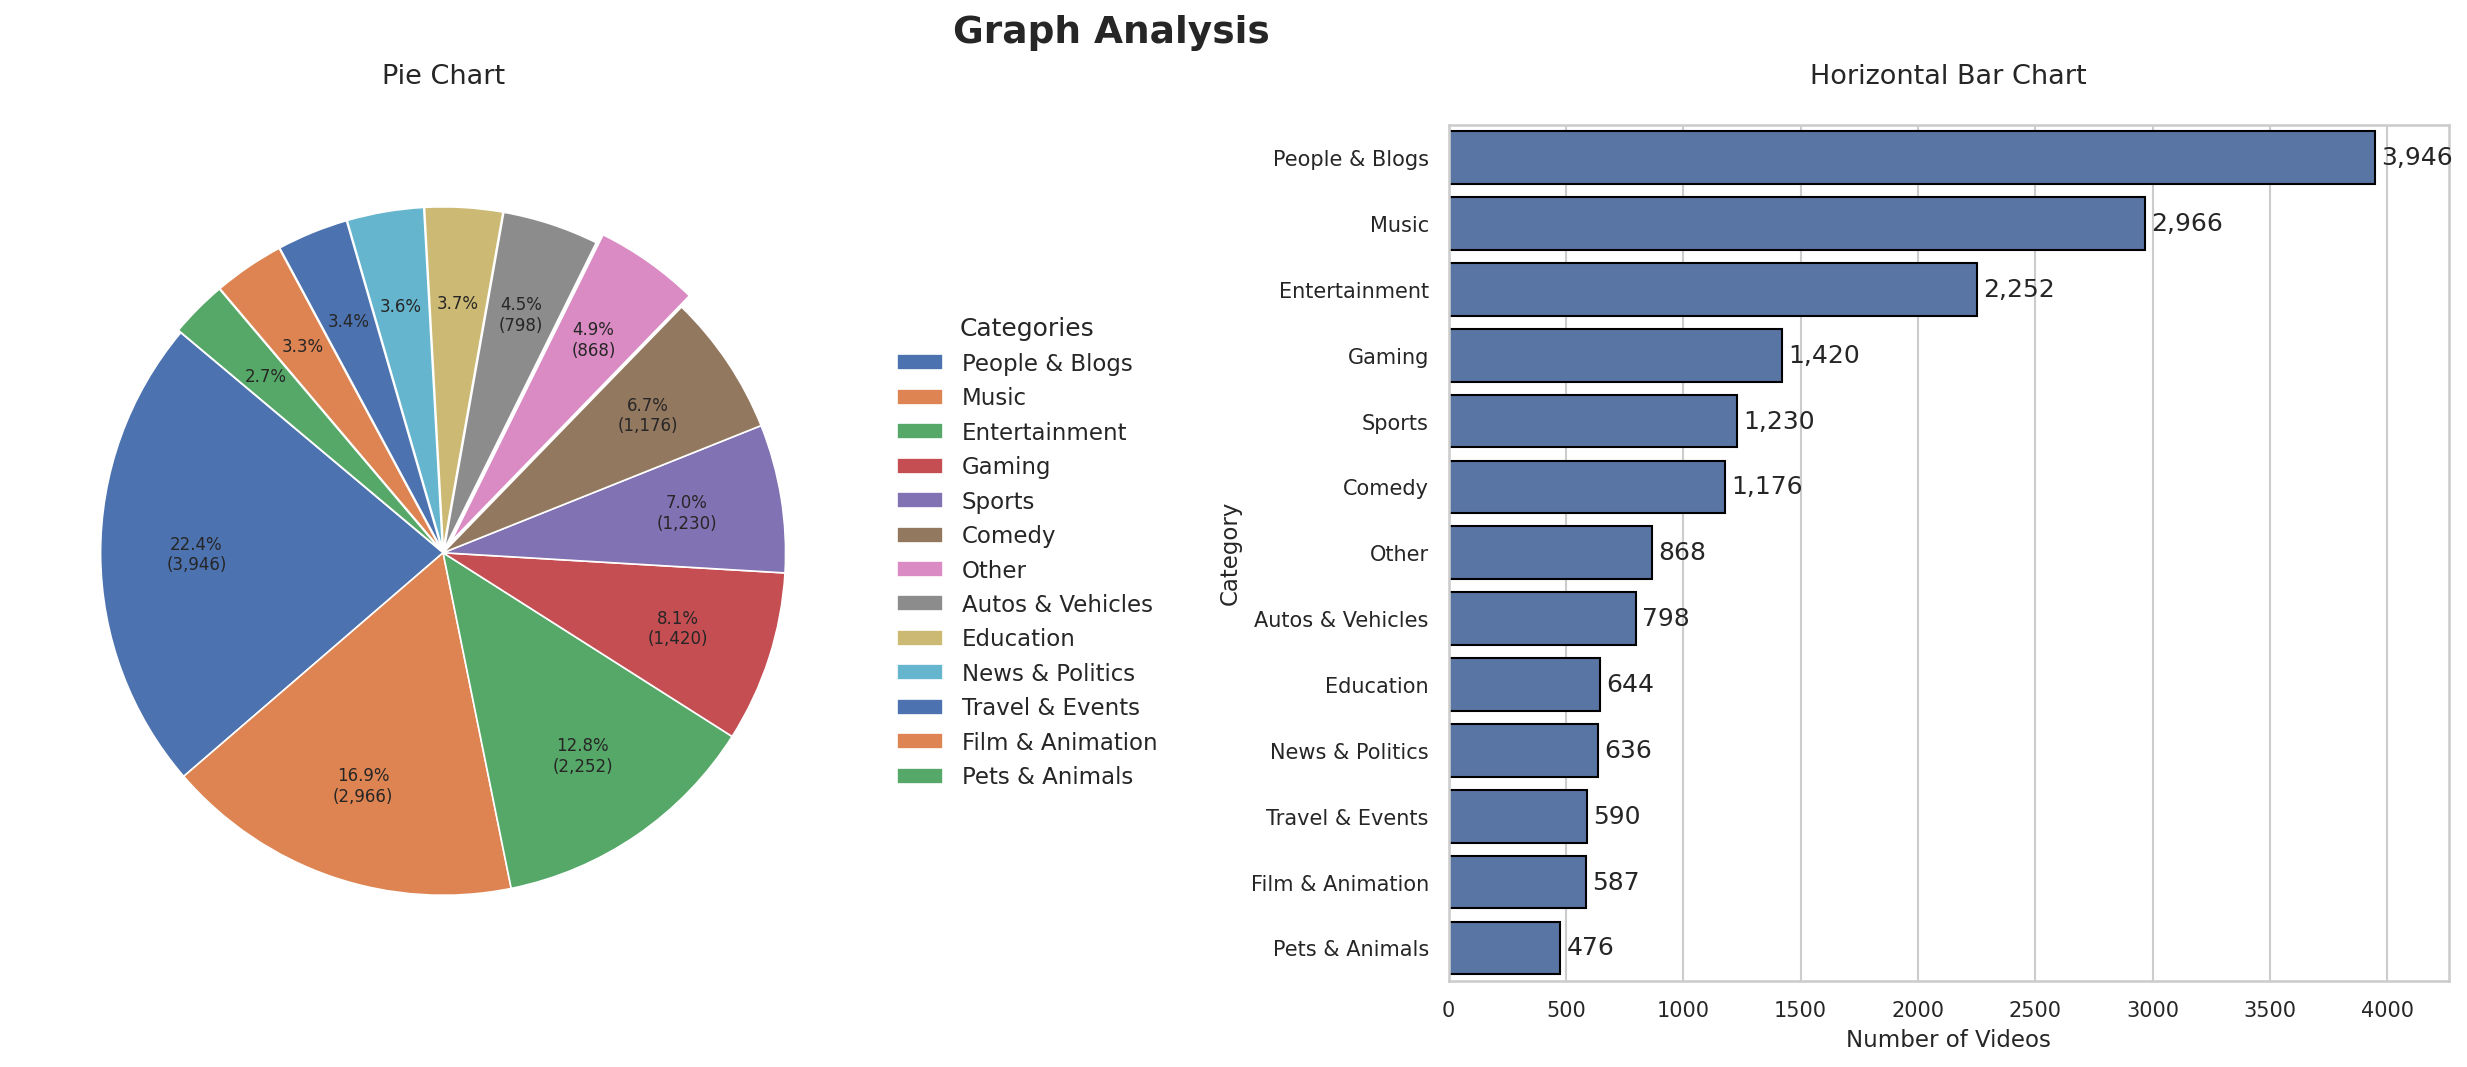

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import textwrap
from matplotlib.gridspec import GridSpec

if 'category' in df_with_transcripts.columns:
    cat_col = 'category'
elif 'category_id' in df_with_transcripts.columns:
    cat_col = 'category_id'
else:
    raise ValueError("No category column found. Please check your data.")

category_counts = (
    df_with_transcripts[cat_col]
    .astype(str)
    .fillna("Unknown")
    .value_counts()
    .rename_axis(cat_col)
    .reset_index(name='Count')
)

TOP_N = 12
top_df = category_counts.head(TOP_N).copy()
other_sum = category_counts['Count'][TOP_N:].sum()
if other_sum > 0:
    top_df = pd.concat(
        [top_df, pd.DataFrame({cat_col: ["Other"], "Count": [other_sum]})],
        ignore_index=True
    )

top_df = top_df.sort_values("Count", ascending=False).reset_index(drop=True)

def wrap_labels(labels, width=16):
    return ['\n'.join(textwrap.wrap(str(l), width=width)) for l in labels]

wrapped_labels = wrap_labels(top_df[cat_col], width=16)

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

fig = plt.figure(figsize=(18, 7), layout="constrained")
gs = GridSpec(1, 2, figure=fig, width_ratios=[1.35, 1])

fig.suptitle("Graph Analysis", fontsize=18, weight='bold')

#  PIE CHART
ax_pie = fig.add_subplot(gs[0, 0])
counts = top_df["Count"].values
labels = top_df[cat_col].astype(str).values

explode = np.zeros(len(top_df))
if "Other" in labels:
    explode[list(labels).index("Other")] = 0.03
explode = np.where(counts / counts.sum() < 0.05, explode + 0.01, explode)

wedges, texts, autotexts = ax_pie.pie(
    counts,
    labels=None,
    autopct=lambda p: f"{p:.1f}%\n({int(round(p/100.0*counts.sum())):,})" if p >= 4 else f"{p:.1f}%",
    startangle=140,
    wedgeprops=dict(linewidth=0.8, edgecolor="white"),
    explode=explode,
    pctdistance=0.72,
    labeldistance=1.03,
    textprops={'fontsize': 8}
)

ax_pie.set_title("Pie Chart", pad=20)
ax_pie.set_aspect('equal')

legend = ax_pie.legend(
    wedges,
    wrap_labels(labels, width=22),
    title="Categories",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
    borderaxespad=0.0
)

# HORIZONTAL BAR
ax_bar = fig.add_subplot(gs[0, 1])
sns.barplot(
    ax=ax_bar,
    data=top_df,
    y=wrapped_labels,
    x="Count",
    edgecolor="black"
)
ax_bar.set_title("Horizontal Bar Chart", pad=20)
ax_bar.set_xlabel("Number of Videos")
ax_bar.set_ylabel("Category")

for container in ax_bar.containers:
    ax_bar.bar_label(container, fmt=lambda v: f"{int(v):,}", padding=3)

max_count = top_df["Count"].max()
ax_bar.set_xlim(0, max_count * 1.08)

plt.show()